In [1]:
import fsps
import dynesty
import sedpy
import h5py, astropy
import numpy as np

In [2]:
from astropy.io import fits
from astropy.table import Table

In [35]:
# read the data
file = '../data/spec-at2018bsi-host-sdss.fits'
t_spec = Table.read(file, hdu=1)
t_phot = Table.read(file, hdu=2)
mags = t_phot['CMODELMAG'].value[0]
mag_errs = t_phot['CMODELMAGERR'].value[0]
bands = "ugriz"

In [36]:
t_phot

PROGRAMNAME,CHUNK,PLATEQUALITY,PLATESN2,DEREDSN2,PRIMTARGET,SECTARGET,LAMBDA_EFF,BLUEFIBER,ZOFFSET,XFOCAL,YFOCAL,BOSS_TARGET1,BOSS_TARGET2,ANCILLARY_TARGET1,ANCILLARY_TARGET2,EBOSS_TARGET0,EBOSS_TARGET1,EBOSS_TARGET2,EBOSS_TARGET_ID,THING_ID_TARGETING,SPECPRIMARY,SPECBOSS,BOSS_SPECOBJ_ID,NSPECOBS,CALIBFLUX,CALIBFLUX_IVAR,PLATE,TILE,MJD,FIBERID,RUN2D,RUN1D,OBJTYPE,PLUG_RA,PLUG_DEC,CLASS,SUBCLASS,Z,Z_ERR,RCHI2,DOF,RCHI2DIFF,TFILE,TCOLUMN,NPOLY,THETA,VDISP,VDISP_ERR,VDISPZ,VDISPZ_ERR,VDISPCHI2,VDISPNPIX,VDISPDOF,WAVEMIN,WAVEMAX,WCOVERAGE,ZWARNING,SN_MEDIAN,SN_MEDIAN_ALL,CHI68P,FRACNSIGMA,FRACNSIGHI,FRACNSIGLO,SPECTROFLUX,SPECTROFLUX_IVAR,SPECTROSYNFLUX,SPECTROSYNFLUX_IVAR,SPECTROSKYFLUX,ANYANDMASK,ANYORMASK,SPEC1_G,SPEC1_R,SPEC1_I,SPEC2_G,SPEC2_R,SPEC2_I,ELODIE_FILENAME,ELODIE_OBJECT,ELODIE_SPTYPE,ELODIE_BV,ELODIE_TEFF,ELODIE_LOGG,ELODIE_FEH,ELODIE_Z,ELODIE_Z_ERR,ELODIE_Z_MODELERR,ELODIE_RCHI2,ELODIE_DOF,Z_NOQSO,Z_ERR_NOQSO,ZNUM_NOQSO,ZWARNING_NOQSO,CLASS_NOQSO,SUBCLASS_NOQSO,RCHI2DIFF_NOQSO,VDISP_LNL,SPECOBJID,OBJID,PARENTID,FIELDID,SKYVERSION,MODE,CLEAN,RUN,RERUN,CAMCOL,FIELD,ID,PARENT,NCHILD,OBJC_TYPE,OBJC_PROB_PSF,OBJC_FLAGS,OBJC_FLAGS2,OBJC_ROWC,OBJC_ROWCERR,OBJC_COLC,OBJC_COLCERR,ROWVDEG,ROWVDEGERR,COLVDEG,COLVDEGERR,ROWC,ROWCERR,COLC,COLCERR,PETROTHETA,PETROTHETAERR,PETROTH50,PETROTH50ERR,PETROTH90,PETROTH90ERR,Q,QERR,U,UERR,M_E1,M_E2,M_E1E1ERR,M_E1E2ERR,M_E2E2ERR,M_RR_CC,M_RR_CCERR,M_CR4,M_E1_PSF,M_E2_PSF,M_RR_CC_PSF,M_CR4_PSF,THETA_DEV,THETA_DEVERR,AB_DEV,AB_DEVERR,THETA_EXP,THETA_EXPERR,AB_EXP,AB_EXPERR,FRACDEV,FLAGS,FLAGS2,TYPE,PROB_PSF,NPROF,PROFMEAN_NMGY,PROFERR_NMGY,STAR_LNL,EXP_LNL,DEV_LNL,PSP_STATUS,PIXSCALE,RA,DEC,CX,CY,CZ,RAERR,DECERR,L,B,OFFSETRA,OFFSETDEC,PSF_FWHM,AIRMASS,PHI_OFFSET,PHI_DEV_DEG,PHI_EXP_DEG,EXTINCTION,SKYFLUX,SKYFLUX_IVAR,PSFFLUX,PSFFLUX_IVAR,PSFMAG,PSFMAGERR,FIBERFLUX,FIBERFLUX_IVAR,FIBERMAG,FIBERMAGERR,FIBER2FLUX,FIBER2FLUX_IVAR,FIBER2MAG,FIBER2MAGERR,CMODELFLUX,CMODELFLUX_IVAR,CMODELMAG,CMODELMAGERR,MODELFLUX,MODELFLUX_IVAR,MODELMAG,MODELMAGERR,PETROFLUX,PETROFLUX_IVAR,PETROMAG,PETROMAGERR,DEVFLUX,DEVFLUX_IVAR,DEVMAG,DEVMAGERR,EXPFLUX,EXPFLUX_IVAR,EXPMAG,EXPMAGERR,APERFLUX,APERFLUX_IVAR,CLOUDCAM,CALIB_STATUS,NMGYPERCOUNT,NMGYPERCOUNT_IVAR,TAI,RESOLVE_STATUS,THING_ID,IFIELD,BALKAN_ID,NOBSERVE,NDETECT,NEDGE,SCORE
bytes27,bytes14,bytes4,float32,float32,int32,int32,float32,int32,float32,float32,float32,int64,int64,int64,int64,int64,int64,int64,int64,int64,uint8,uint8,int32,int16,float32[5],float32[5],int32,int32,int32,int32,bytes7,bytes7,bytes16,float64,float64,bytes6,bytes21,float32,float32,float32,int32,float32,bytes24,int32[10],int32,float32[10],float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,int32,float32[5],float32,float32,float32[10],float32[10],float32[10],float32[5],float32[5],float32[5],float32[5],float32[5],int32,int32,float32,float32,float32,float32,float32,float32,bytes16,bytes9,bytes12,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,int32,int32,bytes6,bytes21,float32,float32[35],uint64,bytes19,bytes19,bytes19,uint8,uint8,uint8,int16,bytes3,uint8,int16,int16,int16,int16,int32,float32,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],int32[5],int32[5],int32[5],float32[5],int32[5],"float32[5,15]","float32[5,15]",float32[5],float32[5],float32[5],int32[5],float32[5],float64,float64,float64,float64,float64,float64,float64,float64,float64,float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32[

In [42]:
from sedpy.observate import load_filters
from prospect.utils.obsutils import fix_obs

filters = load_filters([f"sdss_{b}0" for b in bands])
maggies = np.array([10**(-0.4 * m) for m in mags])
magerr = np.array([m for m in mag_errs])
magerr = np.clip(magerr, 0.05, np.inf)

obs = dict(wavelength=None, spectrum=None, unc=None, redshift=t_phot["Z"].value,
           maggies=maggies, maggies_unc=magerr * maggies / 1.086, filters=filters)
obs = fix_obs(obs)

#try example photometry to see if mine is just weird
# from astroquery.sdss import SDSS
# from astropy.coordinates import SkyCoord
# bands = "ugriz"
# mcol = [f"cModelMag_{b}" for b in bands]
# ecol = [f"cModelMagErr_{b}" for b in bands]
# cat = SDSS.query_crossid(SkyCoord(ra=204.46376, dec=35.79883, unit="deg"),
#                          data_release=16,
#                          photoobj_fields=mcol + ecol + ["specObjID"])
# shdus = SDSS.get_spectra(plate=2101, mjd=53858, fiberID=220)[0]
# assert int(shdus[2].data["SpecObjID"][0]) == cat[0]["specObjID"]

# from sedpy.observate import load_filters
# from prospect.utils.obsutils import fix_obs

# filters = load_filters([f"sdss_{b}0" for b in bands])
# maggies = np.array([10**(-0.4 * cat[0][f"cModelMag_{b}"]) for b in bands])
# magerr = np.array([cat[0][f"cModelMagErr_{b}"] for b in bands])
# magerr = np.clip(magerr, 0.05, np.inf)

# obs = dict(wavelength=None, spectrum=None, unc=None, redshift=shdus[2].data[0]["z"],
#            maggies=maggies, maggies_unc=magerr * maggies / 1.086, filters=filters)
# obs = fix_obs(obs)

In [43]:
from prospect.models.templates import TemplateLibrary
from prospect.models import SpecModel
model_params = TemplateLibrary["parametric_sfh"]
model_params.update(TemplateLibrary["nebular"])
model_params["zred"]["init"] = obs["redshift"]

model = SpecModel(model_params)
assert len(model.free_params) == 5
print(model)

:::::::
<class 'prospect.models.sedmodel.SpecModel'>

Free Parameters: (name: prior) 
-----------
  mass: <class 'prospect.models.priors.LogUniform'>(mini=100000000.0,maxi=1000000000000.0)
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-2,maxi=0.19)
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=2.0)
  tage: <class 'prospect.models.priors.TopHat'>(mini=0.001,maxi=13.8)
  tau: <class 'prospect.models.priors.LogUniform'>(mini=0.1,maxi=30)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  zred: [0.05100077] 
  sfh: [4] 
  imf_type: [2] 
  dust_type: [0] 
  add_neb_emission: [ True] 
  add_neb_continuum: [ True] 
  nebemlineinspec: [ True] 
  gas_logz: [0.] <function stellar_logzsol at 0x14dc79f70>
  gas_logu: [-2.] 


In [44]:
noise_model = (None, None)

In [45]:
from prospect.sources import CSPSpecBasis
sps = CSPSpecBasis(zcontinuous=1)
print(sps.ssp.libraries)

(b'mist', b'miles', b'DL07')


In [46]:
current_parameters = ",".join([f"{p}={v}" for p, v in zip(model.free_params, model.theta)])
print(current_parameters)
spec, phot, mfrac = model.predict(model.theta, obs=obs, sps=sps)
print(phot / obs["maggies"])

mass=10000000000.0,logzsol=-0.5,dust2=0.6,tage=1.0,tau=1.0
[3.36921955 2.32765963 1.08630908 0.95859236 0.72839511]


In [33]:
from prospect.fitting import lnprobfn, fit_model
fitting_kwargs = dict(nlive_init=400, 
                      nested_method="rwalk", 
                      nested_target_n_effective=1000, 
                      nested_dlogz_init=0.05)

output = fit_model(obs, model, sps, 
                   optimize=False, dynesty=True, 
                   lnprobfn=lnprobfn, noise=noise_model, 
                   **fitting_kwargs)

result, duration = output["sampling"]

iter: 1367 | batch: 0 | nc: 1 | ncall: 30998 | eff(%):  4.410 | logz: 78.284 +/-  0.279 | dlogz:  0.000 >  0.050        


done dynesty (initial) in 1928.839681148529s


iter: 2166 | batch: 3 | nc: 1 | ncall: 42717 | eff(%):  4.399 | loglstar: 83.850 < 87.495 < 84.178 | logz: 78.316 +/-  0.245 | stop:  1.020      

done dynesty (dynamic) in 626.6134850978851s


In [34]:
result

         niter: 1866
         ncall: array([1, 1, 1, ..., 1, 1, 1])
           eff: 4.399179574227315
       samples: array([[ 3.20697050e+11, -3.16209512e-01,  3.75162499e-01,
         3.01652608e-01,  2.28617675e-01],
       [ 7.57540704e+11, -1.95320172e+00,  2.91756106e-01,
         1.86875964e+00,  8.66601008e+00],
       [ 2.25598607e+11, -8.88249202e-01,  1.18496287e+00,
         2.80451876e-01,  3.25666510e-01],
       ...,
       [ 1.05675687e+11, -1.83652913e+00,  1.25940651e+00,
         4.06973184e+00,  1.25807786e-01],
       [ 1.12873171e+11, -1.97628601e+00,  1.23713796e+00,
         4.76125556e+00,  2.20318810e-01],
       [ 1.03644274e+11, -1.86168670e+00,  1.28685125e+00,
         3.97836785e+00,  1.99929450e-01]])
    samples_id: array([47,  8, 88, ..., 54, 67,  4])
 samples_batch: array([0, 0, 0, ..., 0, 0, 0])
    samples_it: array([   0,    0,    0, ..., 1023, 1038, 1236])
     samples_u: array([[0.87652374, 0.7688541 , 0.18758125, 0.021788  , 0.14497062],
       

In [47]:
from prospect.io import write_results as writer
hfile = "./quickstart_dynesty_mcmc.h5"
writer.write_hdf5(hfile, {}, model, obs,
                 output["sampling"][0], None,
                 sps=sps,
                 tsample=output["sampling"][1],
                 toptimize=0.0)

/Users/mitchell/opt/anaconda3/lib/python3.9/site-packages/prospect/io/write_results.py:60: RuntimeWarning: Could not store paramfile text
  warnings.warn("Could not store paramfile text", RuntimeWarning)
/Users/mitchell/opt/anaconda3/lib/python3.9/site-packages/prospect/io/write_results.py:290: RuntimeWarning: Could not JSON serialize model_params, pickled instead
  warnings.warn("Could not JSON serialize {}, pickled instead".format(k),
/Users/mitchell/opt/anaconda3/lib/python3.9/site-packages/prospect/io/write_results.py:49: RuntimeWarning: Could not obtain prospector version info
  warnings.warn("Could not obtain prospector version info", RuntimeWarning)


In [48]:
from prospect.io import read_results as reader
hfile = "./quickstart_dynesty_mcmc.h5"
out, out_obs, out_model = reader.results_from(hfile)

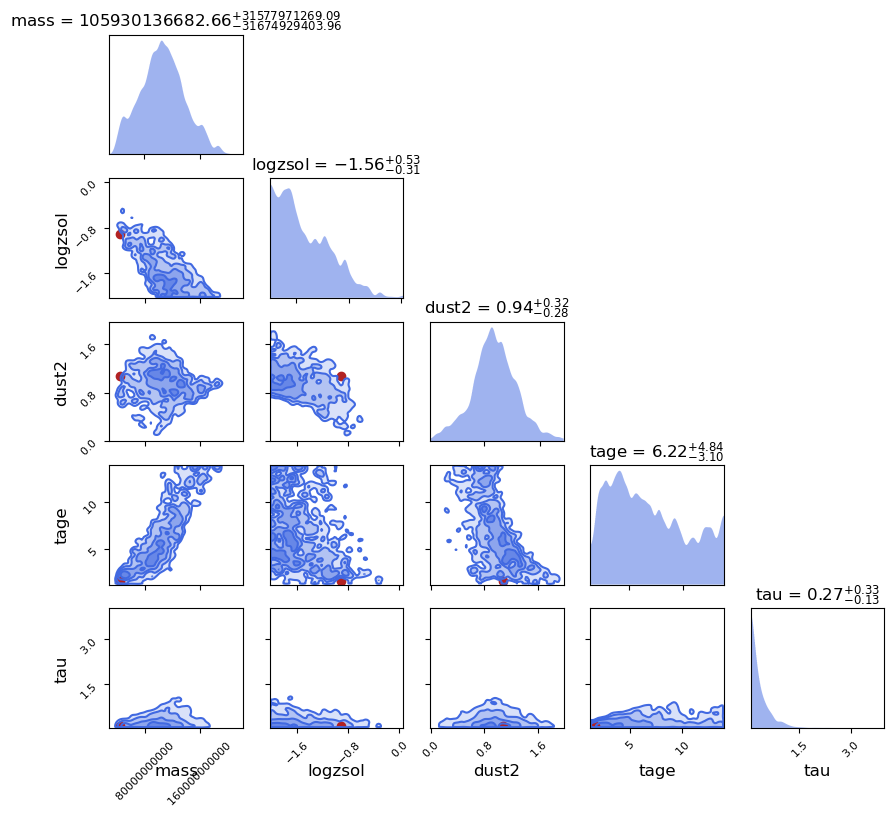

In [49]:
import matplotlib.pyplot as pl
from prospect.plotting import corner
nsamples, ndim = out["chain"].shape
cfig, axes = pl.subplots(ndim, ndim, figsize=(10,9))
axes = corner.allcorner(out["chain"].T, out["theta_labels"], axes, weights=out["weights"], color="royalblue", show_titles=True)

from prospect.plotting.utils import best_sample
pbest = best_sample(out)
corner.scatter(pbest[:, None], axes, color="firebrick", marker="o")

Text(0, 0.5, '$\\chi_{\\rm best}$')

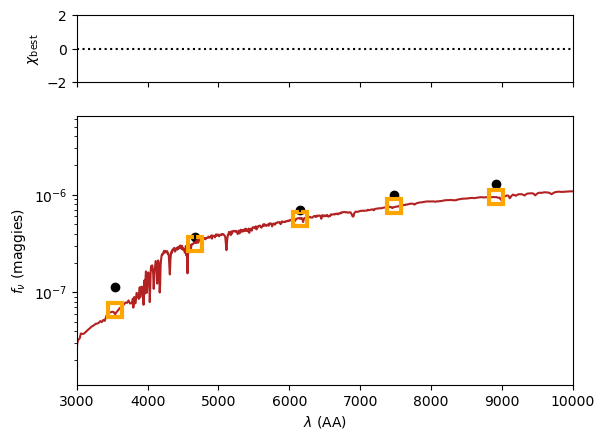

In [50]:
import matplotlib.pyplot as pl
sfig, saxes = pl.subplots(2, 1, gridspec_kw=dict(height_ratios=[1, 4]), sharex=True)
ax = saxes[1]
pwave = np.array([f.wave_effective for f in out_obs["filters"]])
# plot the data
ax.plot(pwave, out_obs["maggies"], linestyle="", marker="o", color="k")
ax.errorbar(pwave,  out_obs["maggies"], out_obs["maggies_unc"], linestyle="", color="k", zorder=10)
ax.set_ylabel(r"$f_\nu$ (maggies)")
ax.set_xlabel(r"$\lambda$ (AA)")
ax.set_xlim(3e3, 1e4)
ax.set_ylim(out_obs["maggies"].min() * 0.1, out_obs["maggies"].max() * 5)
ax.set_yscale("log")

# get the best-fit SED
bsed = out["bestfit"]
ax.plot(bsed["restframe_wavelengths"] * (1+out_obs["redshift"]), bsed["spectrum"], color="firebrick", label="MAP sample")
ax.plot(pwave, bsed["photometry"], linestyle="", marker="s", markersize=10, mec="orange", mew=3, mfc="none")

ax = saxes[0]
chi = (out_obs["maggies"] - bsed["photometry"]) / out_obs["maggies_unc"]
ax.plot(pwave, chi, linestyle="", marker="o", color="k")
ax.axhline(0, color="k", linestyle=":")
ax.set_ylim(-2, 2)
ax.set_ylabel(r"$\chi_{\rm best}$")